In [1]:
from fact.io import read_h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
test = read_h5py("data/gamma_test_dl3.hdf5", key="events")
crab = read_h5py("data/open_crab_sample_dl3.hdf5", key="events")
crab_runs = read_h5py("data/open_crab_sample_dl3.hdf5", key="runs")

gamma_test = test["gamma_prediction"] >= 0.8
gamma_crab = crab["gamma_prediction"] >= 0.8

In [3]:
# Import and square angle theta of on- and off-positions from dataframe (all off positions flattened to one array)
theta2_s = crab["theta_deg"][gamma_crab].to_numpy()**2
theta2_bg = crab[["theta_deg_off_1","theta_deg_off_2","theta_deg_off_3","theta_deg_off_4","theta_deg_off_5"]][gamma_crab].to_numpy().flatten()**2

# Create histograms for on- and off-positions 
hist_s, bins_s = np.histogram(theta2_s[theta2_s<=np.sqrt(0.025)], bins=20)
hist_bg, bins_bg = np.histogram(theta2_bg[theta2_bg<=np.sqrt(0.025)], bins=20)

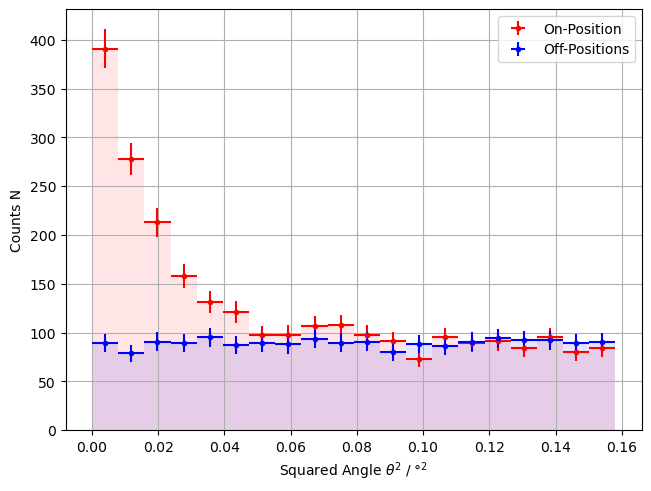

In [4]:
fig, ax = plt.subplots(constrained_layout=True)

x = bins_s[:-1] + np.diff(bins_s)/2

ax.stairs(hist_s,bins_s,fill="True",alpha=0.1,color="r")
ax.errorbar(x,hist_s,yerr=np.sqrt(hist_s),xerr=np.diff(bins_s)/2,fmt="r.",label="On-Position")
ax.stairs(hist_bg/5,bins_bg,fill="True",alpha=0.1,color="b") # divided by 5 due to 5 off positions -> average over off-positions
ax.errorbar(x,hist_bg/5,yerr=np.sqrt(hist_bg/5),xerr=np.diff(bins_bg)/2,fmt="b.",label="Off-Positions")

ax.set_xlabel(r"Squared Angle $\theta^2 \;/ \; \degree^2$")
ax.set_ylabel(r"Counts N")
ax.grid()
ax.legend(loc="best")
plt.show()

In [5]:
# Calculate Number of On- and Off-Events for theta^2 cut of 0.025 
N_on = len(theta2_s[theta2_s<=np.sqrt(0.025)])
N_off = len(theta2_bg[theta2_bg<=np.sqrt(0.025)])

# Alpha is size-factor of on- to off-region
alpha = 0.2

# Calculate significance with Likelihood-Ratio-Test due to Li & Ma
S = np.sqrt(2) * np.sqrt(N_on * np.log( (1+alpha)/alpha * N_on/(N_on + N_off)) + N_off * np.log((1+alpha) * N_off/(N_on + N_off)))
print(S)

15.989754417879428


In [124]:
# Import measured and true energies of events from dataframe
E_true = test["corsika_event_header_total_energy"][gamma_test].to_numpy()
E_pred = test["gamma_energy_prediction"][gamma_test].to_numpy()

# Create logarithmic bin edges for histograms
bins_true=np.logspace(np.log10(500),np.log10(15000),6)
bins_pred=np.logspace(np.log10(500),np.log10(15000),11)

# Add under-/overflow bins if necessary
if np.any(E_true<500): 
    bins_true = np.append(0,bins_true)
if np.any(E_true>15000): 
    bins_true = np.append(bins_true,np.inf)
if np.any(E_pred<500): 
    bins_pred = np.append(0,bins_pred)
if np.any(E_pred>15000): 
    bins_pred = np.append(bins_pred,np.inf)

# Create histograms of measured and true data
hist_E_true, bins_E_true = np.histogram(E_true, bins_true)
hist_E_pred, bins_E_pred = np.histogram(E_pred, bins_pred)

In [128]:
# Calculate energy migration matrix as 2D-histogram of measured and true data
A, _, _ = np.histogram2d(E_pred, E_true, bins=[bins_pred, bins_true])


# Normalize A
A = A/np.sum(A,axis=0)
print(np.sum(A,axis=0)) # Check if normalized: should all be 1


# Check if forward folding with A gives the same histogram as measured data (hist_E_pred)
g = A@hist_E_true


# Naive SVD Unfolding
A_inv = np.linalg.pinv(A,rcond=0)

f = A_inv@hist_E_pred


# Log-Likelihood Unfolding
def loglikelihood(f,g):
    L_poisson = np.empty(len(g))
    for i in range(len(g)):
        L_poisson[i] = -g[i] * np.log(A @ f)[i] + (A@f)[i]
    L_poisson = L_poisson.sum()
    return L_poisson

def loglikelihood_jac(f,g):
    L_poisson = np.empty(len(f))
    
    for i in range(len(f)):
        L_poisson[i] = -g @ (A[:,i] / (A @ f)) + A[:,i].sum()
        
    return L_poisson

        
x0=10000*np.ones(len(f))
x0 ,_ = np.histogram(E_pred,bins_true)

min_l_test = minimize(loglikelihood,x0,args=(hist_E_pred),method="BFGS",jac=loglikelihood_jac)
err_test = np.sqrt(np.diag(min_l_test.hess_inv))

[1. 1. 1. 1. 1. 1. 1.]


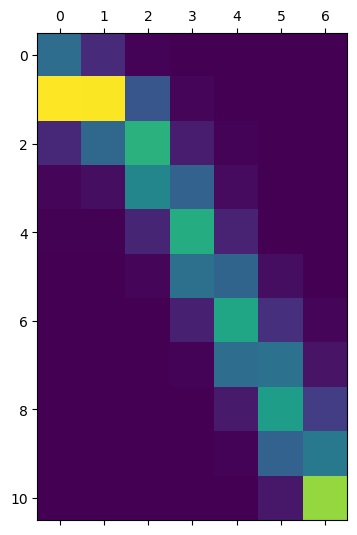

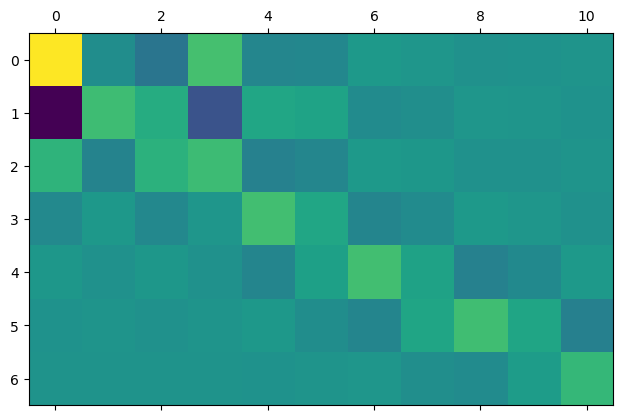

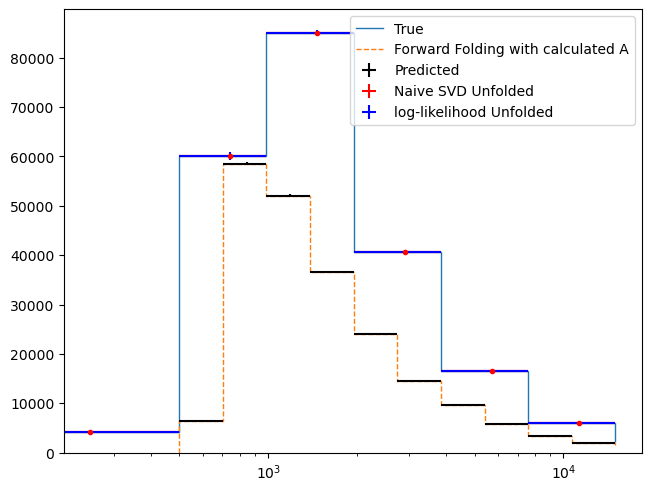

In [126]:
# OBSOLET FÜR DAS PROTOKOLL
#
#

plt.matshow(A)
plt.matshow(A_inv)

fig, ax = plt.subplots(constrained_layout=True)
x_true = bins_E_true[:-1] + np.diff(bins_E_true)/2
x_pred = bins_E_pred[:-1] + np.diff(bins_E_pred)/2
width_pred = np.diff(bins_E_pred)/2
width_true = np.diff(bins_E_true)/2

ax.stairs(hist_E_true,bins_E_true,label="True")
ax.errorbar(x_true, hist_E_true, xerr=width_true, fmt="r.")
ax.errorbar(x_pred, hist_E_pred, yerr=np.sqrt(hist_E_pred), xerr=width_pred, fmt="None", ecolor="k", label="Predicted")
ax.stairs(g,bins_E_pred,linestyle="--",label="Forward Folding with calculated A")
ax.errorbar(x_true, f, xerr=width_true,yerr=sig, fmt="None", ecolor="r", label="Naive SVD Unfolded")
ax.errorbar(x_true, min_l_test.x, yerr=err_test, xerr=width_true, fmt="None", ecolor="b", label="log-likelihood Unfolded")

ax.set_xscale("log")
ax.legend(loc="best")

plt.show()

#
#
# OBSOLET FÜR DAS PROTOKOLL

In [127]:
# Get Crab Nebula measured Energies
E_crab = crab["gamma_energy_prediction"][gamma_crab].to_numpy()

# Make energy histogram
g_crab, bins_E_crab = np.histogram(E_crab, bins_pred)

# Naive SVD Unfolding
f_crab = A_inv@g_crab

x0,_=np.histogram(E_crab,bins_true)

# Poisson Likelihood Unfolding
min_l = minimize(loglikelihood,x0,args=(g_crab),method="BFGS",jac=loglikelihood_jac)
f_like = min_l.x
err_f = np.sqrt(np.diag(min_l.hess_inv))
print(min_l)

      fun: -360124.34702942485
 hess_inv: array([[ 54724.42836601, -69333.42914473,  22065.32762906,
         -6800.435676  ,   2311.73485341,   -808.59074477,
           307.00407017],
       [-69333.42914473, 111585.06646057, -44495.76312283,
         12554.31229197,  -3592.41447068,   1143.49434413,
          -382.88602613],
       [ 22065.32762906, -44495.76312283,  49977.66599448,
        -16549.42917015,   4666.44229857,  -1371.54056876,
           215.72068849],
       [ -6800.435676  ,  12554.31229197, -16549.42917015,
         26736.1860518 ,  -9799.81183734,   3412.48836273,
          -913.33523529],
       [  2311.73485341,  -3592.41447068,   4666.44229857,
         -9799.81183734,  16723.97233389,  -7328.97621436,
          1946.54702569],
       [  -808.59074477,   1143.49434413,  -1371.54056876,
          3412.48836273,  -7328.97621436,  12246.51210596,
         -4529.16289007],
       [   307.00407017,   -382.88602613,    215.72068849,
          -913.33523529,   1946.547

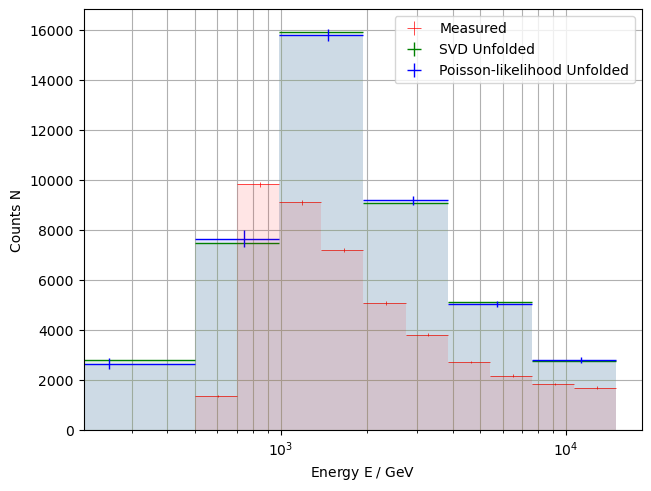

In [121]:
fig, ax = plt.subplots(constrained_layout=True)

x_crab = bins_E_crab[:-1] + np.diff(bins_E_crab)/2

ax.stairs(g_crab[:-1], bins_E_crab[:-1], color="r",linewidth="0.5", zorder=3 ,fill="True",alpha=0.1)
ax.errorbar(x_crab, g_crab, xerr=width_pred, yerr=np.sqrt(g_crab), fmt="none", ecolor="r", elinewidth=0.5, label="Measured")
ax.stairs(f_crab[:-1], bins_E_true[:-1], color="g",linewidth="0.5", zorder=2,fill="True",alpha=0.1)
ax.errorbar(x_true, f_crab, xerr=width_true, yerr=sig, fmt="None", ecolor="g", elinewidth=1, label="SVD Unfolded")
ax.stairs(f_like[:-1], bins_E_true[:-1], color="b",linewidth="0.5", zorder=1,fill="True",alpha=0.1)
ax.errorbar(x_true, f_like, xerr=width_true, yerr=err_f, fmt="none", ecolor="b", elinewidth=1, label="Poisson-likelihood Unfolded")

ax.set_xlabel(r"Energy E$\;/\; $GeV")
ax.set_ylabel(r"Counts N")

ax.set_xscale("log")
ax.grid(which="both")
ax.legend(loc="best")

plt.show()

In [110]:
A_tot = np.pi*270**2
N_sel, _ = np.histogram(E_pred,bins_true[1:-1])
N_sim = hist_E_true[1:-1]
A_eff = N_sel/N_sim/0.7 * A_tot
print(A_eff/A_tot)

[1.54340362 1.49183746 1.35893042 1.33380345 1.25633063]


In [111]:
# Import observation time, sum
t_obs = crab_runs["ontime"][gamma_crab].to_numpy()
t_obs = t_obs.sum()


# Calculate width of energy bins
dE = np.diff(bins_E_true)[1:-1]
print(dE)

# Calculate flux for unfolded event counts with SVD and Poisson-likelihood method
phi_crab = f_crab[1:-1] / (A_eff * dE * t_obs) 
phi_like = f_like[1:-1] / (A_eff * dE * t_obs) 
# Unit: GeV^-1 m^-2 s^-1 = 10 * TeV^-1 cm^-2 s^-1

[ 487.17524292  961.85467754 1899.0382499  3749.36709132 7402.56473832]


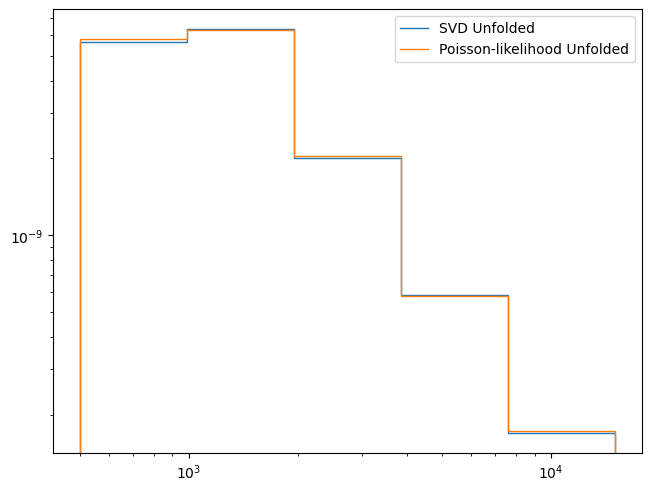

In [112]:
# OBSOLET FÜR DAS PROTOKOLL
#
#

fig, ax = plt.subplots(constrained_layout=True)

ax.stairs(phi_crab,bins_E_true[1:-1],label="SVD Unfolded")
ax.stairs(phi_like,bins_E_true[1:-1],label="Poisson-likelihood Unfolded")

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")

plt.show()

#
#
# OBSOLET FÜR DAS PROTOKOLL

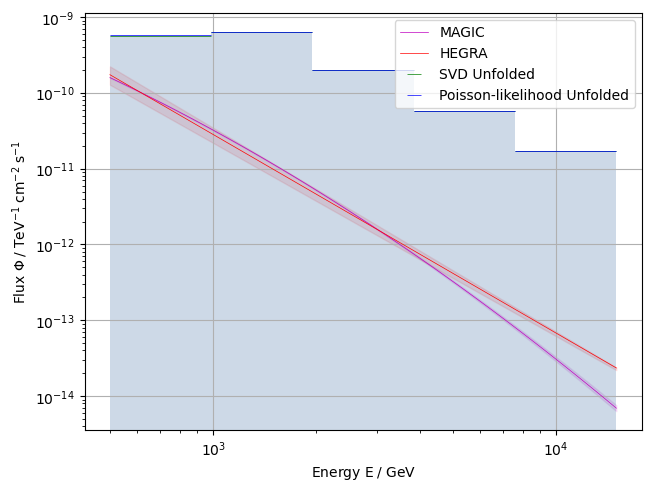

In [113]:
phi_magic = lambda E,phi0,a,b: phi0 * (E/1000) ** (a + b*np.log(E/1000))
phi_hegra = lambda E,phi0,gamma: phi0 * (E/1000) ** (gamma)

phi_magic_params = np.array([[3.23e-11,-2.47,-0.24],[3.26e-11,-2.48,-0.25],[3.2e-11,-2.46,-0.23]])
phi_hegra_params = np.array([[2.83e-11,-2.62],[3.47e-11,-2.69],[2.19e-11,-2.55]])


E = np.logspace(np.log10(500),np.log10(15000),100)

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(E,phi_magic(E, *phi_magic_params[0]), "m-", linewidth=0.5,  label="MAGIC")
ax.fill_between(E, phi_magic(E, *phi_magic_params[2]), phi_magic(E,*phi_magic_params[1]), color="m", alpha=0.1)
ax.plot(E,phi_hegra(E, *phi_hegra_params[0]), "r-", linewidth=0.5, label="HEGRA")
ax.fill_between(E, phi_hegra(E,*phi_hegra_params[2]), phi_hegra(E,*phi_hegra_params[1]), color="r", alpha=0.1)


ax.stairs(phi_crab/10, bins_E_true[1:-1], color="g",linewidth=0.5, fill="True", alpha=0.1)
ax.errorbar(x_true[1:-1], phi_crab/10, xerr=width_true[1:-1], fmt="none", ecolor="g", elinewidth=0.5, label="SVD Unfolded")
ax.stairs(phi_like/10, bins_E_true[1:-1], color="b",linewidth=0.5, fill="True", alpha=0.1)
ax.errorbar(x_true[1:-1], phi_like/10, xerr=width_true[1:-1], fmt="none", ecolor="b", elinewidth=0.5, label="Poisson-likelihood Unfolded")

ax.set_xlabel(r"Energy E$\;/\; $GeV")
ax.set_ylabel(r"Flux $\Phi \;/\; $TeV$^{-1}\; $cm$^{-2}\; $s$^{-1}$")

ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")

plt.show()